In [1]:
# import packages

import praw
import pickle
# import pymongo
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import defaultdict 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# DATA COLLECTION

For the data acquisition, I researched about available methods for web scraping - including __Selenium__ and __BeautifulSoup__.
There are a number of Reddit datasets available on Bigquery and Kaggle as well.

I then came across __PRAW: The Python Reddit API Wrapper__

For the purpose of creating my own dataset instead of the readily available alternatives, I went ahead with PRAW.

## Creating a read-only Reddit instance

In [2]:
# client_id='PERSONAL_USE_SCRIPT_14_CHARS', 
# client_secret='SECRET_KEY_27_CHARS ', 
# user_agent='YOUR_APP_NAME'
reddit = praw.Reddit(client_id='R30fcxAZLJ7Wyw',
                     client_secret='8Zf87krHYa_zXRXPWEF8hK2Twfs',
                     user_agent='project1'
                    )
print(reddit.read_only)

True


## Accessing the India Subreddit

In [3]:
india_subreddit = reddit.subreddit('india')
print(india_subreddit.description)

### We are looking for additional moderators. If you believe you can help, apply [via modmail](https://www.reddit.com/message/compose?to=%2Fr%2Findia)

###[r/India Rules](https://www.reddit.com/r/India/wiki/rules)

###[PushBullet Notifications](https://www.pushbullet.com/channel?tag=redditindia)

###[r/India Discord Server](https://discord.gg/6V29X7f)

###[Scheduled threads](https://www.reddit.com/r/india/comments/b27sx9/scheduled_threads/)

###[r/India twitter](https://twitter.com/redditindia)

#Filters & Hot Topics:

> **Enable**[All](http://www.reddit.com/r/india/#aa)[Non-Political](http://yy.reddit.com/r/india/#yy)[Politics](http://xx.reddit.com/r/india/#xx)[\[R\]eddiquette](http://zz.reddit.com/r/india/#zz)[AMA](https://am.reddit.com/r/india/search?q=flair%3AAMA&sort=new&restrict_sr=on/#am)[Scheduled](https://sd.reddit.com/r/india/search?q=flair%3AScheduled+-title%3ARandom&restrict_sr=on&sort=new&t=all/#sd)[Science & Tech.](http://bb.reddit.com/r/india/#bb)[Self Posts](http://ss.r

## Finding top 10 hot posts of the subreddit

Each subreddit has five different ways of organizing the topics created by redditors: 
1. .hot 
2. .new
3. .controversial 
4. .top
5. .gilded

.search("SEARCH_KEYWORDS") can be used to get only results matching an engine search.

In [4]:
hot_posts = india_subreddit.hot(limit=10)

## Extracting useful data of each post

In [58]:
""" WRONG CODE BLOCK """
"""The following code gave out an error: \
'ValueError: arrays must all be same length' when being converted to a Dataframe."""

# india_posts = defaultdict(list)
# for post in hot_posts:
#     india_posts['title'].append(post.title)
#     india_posts['score'].append(post.score)
#     india_posts['url'].append(post.url)
#     india_posts['num_comments'].append(post.num_comments)
#     india_posts['text'].append(post.selftext)
#     india_posts['created'].append(post.created)
#     
#     for comment in post.comments:
#         india_posts['comments'].append(comment)

# india_posts 

"The following code gave out an error: 'ValueError: arrays must all be same length' when being converted to a Dataframe."

In [40]:
""" CORRECT CODE BLOCK """
india_posts = defaultdict(list)
for post in hot_posts:
    india_posts['title'].append(post.title)
    india_posts['score'].append(post.score)
    india_posts['url'].append(post.url)
    india_posts['num_comments'].append(post.num_comments)
    india_posts['text'].append(post.selftext)
    india_posts['created'].append(post.created)

    #  a limit of None means that all MoreComments objects will be replaced until there are none left
    post.comments.replace_more(limit=None)
    all_comments = ''
    for comment in post.comments:
        all_comments = all_comments + ' ' + comment.body
    
    india_posts['comments'].append(all_comments)

## Converting the collected data to a Dataframe

In [6]:
india_postsdf = pd.DataFrame(india_posts)

# EXPLORATORY DATA ANALYSIS

I noticed that the dates obtained are not legible.
The content of title, innertext and comments contained unrequired data

## Converting the dates to a more readable format

In [7]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [8]:
_timestamp = india_postsdf["created"].apply(get_date)
india_postsdf = india_postsdf.assign(timestamp = _timestamp)
del india_postsdf['created']

## Preprocess function: For Better Text Representation  

In [9]:
def preprocess(text):

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = ''
    for w in word_tokens:
        if w not in stop_words:
            if w.isalnum():
                w = w.lower()
                filtered_sentence = filtered_sentence + ' ' + w
    filtered_sentence = " ".join(filtered_sentence.split())
    return(filtered_sentence)

In [10]:
india_postsdf['title'] = india_postsdf['title'].apply(preprocess)

In [11]:
india_postsdf['comments'] = india_postsdf['comments'].apply(preprocess)

In [12]:
india_postsdf['text'] = india_postsdf['text'].apply(preprocess)

## Saving the dataset to a CSV file

In [13]:
india_postsdf.to_csv('india_posts.csv', index=False)

## Accessing the CSV File

In [13]:
india_posts = pd.read_csv('../Dataset/india_posts.csv')
india_posts.head(10)

,title,score,url,num_comments,text,comments,timestamp
0,coronavirus megathread news updates 4,156,https://www.reddit.com/r/india/comments/g1zi21...,2262,fundraisers donation links https via amnesty i...,fundraisers donation links https via amnesty i...,2020-04-16 09:30:15
1,monthly happiness thread randians please share...,71,https://www.reddit.com/r/india/comments/g4d2ix...,90,3 links feb mht https jan mht https dec mht ht...,working home since past one month for someone ...,2020-04-20 08:20:40
2,facebook buys stake reliance jio rs cr largest...,779,https://economictimes.indiatimes.com/tech/inte...,121,NaN,kiss goodbye privacy so privacy getting sold f...,2020-04-22 15:53:14
3,covidiots arrested paraded making tiktok video...,224,https://www.news18.com/news/buzz/covidiots-arr...,23,NaN,haha die trash play stupid games win stupid pr...,2020-04-22 18:15:57
4,old girl dies walking three days go home,2761,https://i.redd.it/b5ml3vytv6u41.jpg,219,NaN,she passed away hour reaching home so close ye...,2020-04-22 04:56:35
5,ratan tata says redesign slums poor moving awa...,389,https://www.financialexpress.com/economy/ratan...,40,NaN,the tata group ran project industrial design c...,2020-04-22 14:38:14
6,up doctor involved survey tablighi jamat membe...,169,https://www.newindianexpress.com/nation/2020/a...,17,NaN,deleted last week 34 new cases andhra pradesh ...,2020-04-22 17:18:20
7,india 17th nation hit cases death toll crosses...,117,https://m.timesofindia.com/india/india-17th-na...,4,NaN,top 20 reddit defeated pak,2020-04-22 15:38:16
8,indians buried even pakistani kargil soldiers ...,88,https://theprint.in/opinion/pov/indians-buried...,7,NaN,what burying dead soldiers different burying p...,2020-04-22 17:08:29
9,how police used delhi riots teach jamia students,88,https://thewire.in/communalism/jamia-students-...,7,NaN,how rss terrorist personal militant used delhi...,2020-04-22 16:28:11


In [14]:
india_posts.dtypes

title           object
score            int64
url             object
num_comments     int64
text            object
comments        object
timestamp       object
dtype: object

# BUILDING A FLAIR DETECTOR

The tags assigned to each post are called Flairs in the Reddit world. 

With some research, I compiled all the flairs at r/india

In [3]:
flairs={0:'Politics',1:'Non-Political',2:'AskIndia', 3:"[R]eddiquette", 4:'Science/Technology', 5:'Policy/Economy', 6:'Business/Finance', 7:'Scheduled', 8:'Sports', 9:'Food', 10:'Photography', 11:'AMA', 12:'Coronavirus'}

## Data Collection

For Flair Prediction, I figured that date created, score and number of comments won't add much value to the dataset.

I thus selected 
- flair
- title
- url
- text
- comments

as the keys for my dictionary.

In [41]:
data = defaultdict(list)
for flair in flairs:
    search_flair = india_subreddit.search(flairs[flair], limit=100)
    for post in search_flair:
        data['flair'].append(flair)
        data['title'].append(post.title)
        data['url'].append(post.url)
        data['text'].append(post.selftext)
        post.comments.replace_more(limit=None)
        all_comments = ''
        for comment in post.comments:
            all_comments = all_comments + ' ' + comment.body

        data['comments'].append(all_comments)

## Exploratory Data Analysis

In [8]:
# Checking the null values

print(datadf.isnull().sum())

flair         0
title         1
url           0
text        538
comments    129
dtype: int64


I believe that the null columns should not be removed since the actual data will also comprise of missing values.

Removing missing values might result in a better accuracy on the dataset so created.

But, the inferences might not give good results as the training data is not representative of the real world data.

## Data Pre-processing

In [20]:
datadf = pd.DataFrame(data)

datadf['title'] = datadf['title'].apply(preprocess)
datadf['comments'] = datadf['comments'].apply(preprocess)
datadf['text'] = datadf['text'].apply(preprocess)

## Saving to and accessing the CSV File

In [5]:
datadf.to_csv('dataset.csv', index=False)

In [6]:
datadf = pd.read_csv('../Dataset/dataset.csv')
datadf.head(10)

,flair,title,url,text,comments
0,0,a polite request indians,https://www.reddit.com/r/india/comments/g2ct57...,i know situation countries india i seen a lot ...,our society thrives abuse power we let many id...
1,0,pitting community political party fucking stupid,https://www.reddit.com/r/india/comments/futac9...,first let start saying stupid whatever muslims...,our country far moment turning back best hope ...
2,0,hit backlash posts lack medical gear doctors g...,https://theprint.in/india/hit-by-backlash-over...,NaN,well some people really deserve die this count...
3,0,a new political party gave full front page ad ...,https://i.redd.it/yjo9wpy38el41.jpg,NaN,this looks like iipm ad 1 where get funds full...
4,0,politics time corona wb cm questions centre ch...,https://www.timesnownews.com/india/article/pol...,NaN,oh ffs yellow orange green red used emergency ...
5,0,i curious indian politicians think good job po...,https://www.reddit.com/r/india/comments/fs887w...,personally i would pick pinarayi vijayan cpim ...,if anything positive fight covid give credits ...
6,0,in trying time let try little less bit human,https://www.reddit.com/r/india/comments/flm79b...,i shocking interaction morning a bunch us vari...,what incredibly narrow minded person our great...
7,0,aap woeful response delhi communal violence re...,https://scroll.in/article/954991/aaps-woeful-r...,NaN,so argument dms could commanded police armed f...
8,0,politeness actor swara bhasker kunal kamra div...,https://scroll.in/video/952528/f-your-politene...,NaN,i tend agree after first delhi shootings arnab...
9,0,how political satirists like harishankar parsa...,https://www.reddit.com/r/india/comments/fhera0...,this thought came mind i reading parsai works ...,except indira loved dissent they spine back so...


## Class Distribution

In [9]:
# Number of posts
len(datadf['title'])

1218

In [10]:
datadf.flair.value_counts()

12    100
11    100
10    100
9     100
8     100
7     100
6     100
5     100
4     100
2     100
1     100
0     100
3      18
Name: flair, dtype: int64

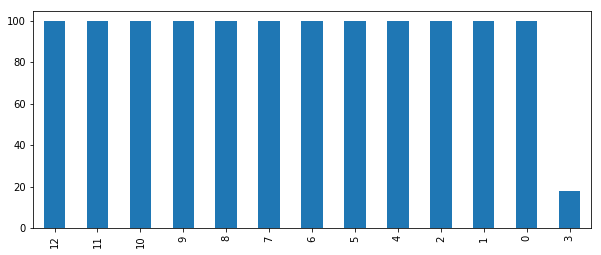

In [11]:
plt.figure(figsize=(10,4))
datadf.flair.value_counts().plot(kind='bar');

I noticed that __the data distribution is imbalanced__, with the [R]eddiquette class having low data as compared to the other classes. This can result in the __minority class being treated as outlier and ignored.__

On researching, I figured that __the [R]eddiquette flair was discontinued 7 months ago.__ Thus, resulting in the less number of posts.

## Dropping the class from the dataset

In [12]:
datadf.drop(datadf[datadf['flair'] == 3].index, inplace = True) 

In [13]:
# Number of posts
len(datadf['title'])

1200

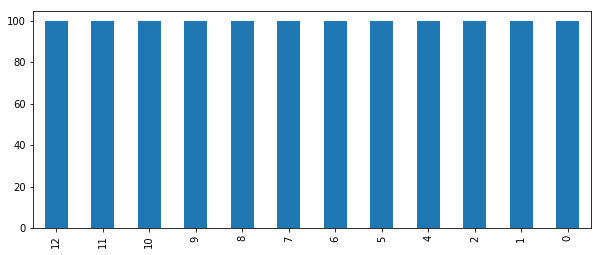

In [14]:
plt.figure(figsize=(10,4))
datadf.flair.value_counts().plot(kind='bar');

## Splitting data into Train and Test Sets

In [22]:
X = datadf.title
X = X.values.astype('U')
y = datadf.flair
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 27)

In [23]:
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (840,)
Number transactions y_train dataset:  (840,)
Number transactions X_test dataset:  (360,)
Number transactions y_test dataset:  (360,)


## Model Selection

Common Text Classification Algorithms : 

logistic regression, support vector machine, naive Bayes classifier, decision trees, random forest

### Logistic Regression

In [24]:
def logistic_reg(X_train, y_train):

    logreg = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=2000)),
                   ])
    lr = logreg.fit(X_train, y_train)
    
    return lr

### Linear Support Vector Machine

In [25]:
def linear_svm(X_train, y_train):

    sgd = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=1000, tol=None)),
                   ])
    svm = sgd.fit(X_train, y_train)
  
    return svm

### Naive Bayes Classifier

In [26]:
def naive_bayes(X_train, y_train):
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    from sklearn.feature_extraction.text import TfidfTransformer

    nb = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', MultinomialNB()),
                  ])
    n = nb.fit(X_train, y_train)

    return n

### Decision Trees

In [27]:
def decision_trees(X_train, y_train):
   
    dt = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', DecisionTreeClassifier()),
                  ])
    d = dt.fit(X_train,y_train)
    
    return d

### Random Forest

In [28]:
def random_forest(X_train, y_train):

    ranfor = Pipeline([('tfidf', TfidfVectorizer()),
                  ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),
                 ])
    rf = ranfor.fit(X_train, y_train)

    return rf

## Comparison of Models

In [29]:
datalr = []
datasvm = []
datanb = []
datadt = []
datarf = []

for i in range(1,8):
    xtr = X_train[0:i*100]
    ytr = y_train[0:i*100]
    clflr = logistic_reg(xtr, ytr)
    clfsvm = linear_svm(xtr, ytr)
    clfnb = naive_bayes(xtr, ytr)
    clfdt = decision_trees(xtr, ytr)
    clfrf = random_forest(xtr, ytr)
    
    datalr.append(clflr.score(X_test,y_test))
    datasvm.append(clfsvm.score(X_test,y_test))
    datanb.append(clfnb.score(X_test,y_test))
    datadt.append(clfdt.score(X_test, y_test))
    datarf.append(clfrf.score(X_test, y_test))

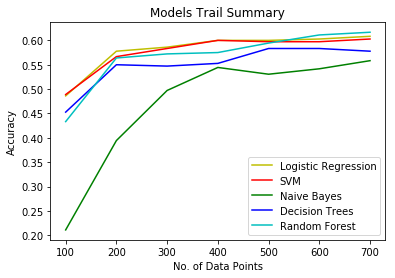

In [30]:
plt.plot([100,200,300,400,500,600,700],datalr,color='y')
plt.plot([100,200,300,400,500,600,700],datasvm,color='r')
plt.plot([100,200,300,400,500,600,700],datanb,color='g')
plt.plot([100,200,300,400,500,600,700],datadt,color='b')
plt.plot([100,200,300,400,500,600,700],datarf,color='c')
plt.gca().legend(('Logistic Regression', 'SVM','Naive Bayes','Decision Trees','Random Forest'))
plt.xlabel('No. of Data Points')
plt.ylabel('Accuracy')
plt.title('Models Trail Summary')
plt.show()

In [31]:
print("Final Accuracies with 800 data points:")
print("Logistic Regression: {} ".format(datalr[-1]))
print("Support Vector Machine: {}".format(datasvm[-1]))
print("Naive Bayes: {}".format(datanb[-1]))
print("Decision Trees: {}".format(datadt[-1]))
print("Random Forest: {}".format(datarf[-1]))

Final Accuracies with 800 data points:
Logistic Regression: 0.6083333333333333 
Support Vector Machine: 0.6027777777777777
Naive Bayes: 0.5583333333333333
Decision Trees: 0.5777777777777777
Random Forest: 0.6166666666666667


Clearly, Random Forest Classifier works best amongst all the classifiers.

## Training Random Forest on the whole dataset

### Using only Title in Dataset

In [32]:
ranfor = Pipeline([('tfidf', TfidfVectorizer()),
                  ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),
                 ])
rf1 = ranfor.fit(X_train, y_train)

y_pred = rf1.predict(X_test)
print('Accuracy: %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.71      0.44      0.55        27
           1       0.47      0.45      0.46        38
           2       0.72      0.64      0.68        36
           4       0.85      0.59      0.70        39
           5       0.56      0.50      0.53        30
           6       0.23      0.53      0.32        30
           7       0.46      0.50      0.48        22
           8       0.82      0.58      0.68        31
           9       0.89      0.89      0.89        27
          10       0.83      0.83      0.83        35
          11       0.83      0.79      0.81        24
          12       0.90      0.86      0.88        21

    accuracy                           0.62       360
   macro avg       0.69      0.63      0.65       360
weighted avg       0.69      0.62      0.64       360



### Using Training Data as Title + Comments

In [33]:
# using title+ comments as training data
X2 = datadf.title + datadf.comments
X2 = X2.values.astype('U')
y2 = datadf.flair
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state = 27)

In [34]:
rf2 = ranfor.fit(X_train2, y_train2)

y_pred = rf2.predict(X_test2)
print('Accuracy: %s' % accuracy_score(y_test2, y_pred))
print(classification_report(y_test2, y_pred))

Accuracy: 0.5694444444444444
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        27
           1       0.67      0.32      0.43        38
           2       0.65      0.31      0.42        36
           4       0.89      0.44      0.59        39
           5       0.74      0.47      0.57        30
           6       0.67      0.53      0.59        30
           7       0.46      0.55      0.50        22
           8       0.63      0.77      0.70        31
           9       0.68      0.70      0.69        27
          10       0.82      0.89      0.85        35
          11       0.40      0.67      0.50        24
          12       0.27      0.86      0.41        21

    accuracy                           0.57       360
   macro avg       0.62      0.59      0.57       360
weighted avg       0.65      0.57      0.57       360



### Using Training Data as Title + Comments + Text

In [35]:
X3 = datadf.title + datadf.comments + datadf.text

X3 = X3.values.astype('U')
y3 = datadf.flair
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state = 27)

In [36]:
rf3 = ranfor.fit(X_train3, y_train3)

y_pred = rf3.predict(X_test3)
print('Accuracy: %s' % accuracy_score(y_test3, y_pred))
print(classification_report(y_test3, y_pred))

Accuracy: 0.35


/home/gunnika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.25      0.03      0.05        38
           2       0.32      0.69      0.44        36
           4       0.83      0.13      0.22        39
           5       0.71      0.50      0.59        30
           6       0.71      0.50      0.59        30
           7       0.80      0.18      0.30        22
           8       0.67      0.32      0.43        31
           9       0.50      0.07      0.13        27
          10       1.00      0.40      0.57        35
          11       0.57      0.71      0.63        24
          12       0.11      0.86      0.20        21

    accuracy                           0.35       360
   macro avg       0.54      0.37      0.35       360
weighted avg       0.55      0.35      0.35       360



Adding the inner text to training data reduced the accuracy drastically. 

This is because from previous observation of null values, the inner text of 538 posts is missing.

### Using Training Data as Title + Comments + URL

In [37]:
X4 = datadf.title + datadf.comments + datadf.url

X4 = X4.values.astype('U')
y4 = datadf.flair
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state = 27)

In [38]:
rf4 = ranfor.fit(X_train4, y_train4)

y_pred = rf4.predict(X_test4)
print('Accuracy: %s' % accuracy_score(y_test4, y_pred))
print(classification_report(y_test4, y_pred))

Accuracy: 0.5861111111111111
              precision    recall  f1-score   support

           0       0.67      0.59      0.63        27
           1       0.71      0.32      0.44        38
           2       0.56      0.56      0.56        36
           4       0.90      0.46      0.61        39
           5       0.73      0.53      0.62        30
           6       0.68      0.57      0.62        30
           7       0.45      0.41      0.43        22
           8       0.67      0.71      0.69        31
           9       0.77      0.63      0.69        27
          10       0.83      0.86      0.85        35
          11       0.42      0.67      0.52        24
          12       0.27      0.86      0.41        21

    accuracy                           0.59       360
   macro avg       0.64      0.60      0.59       360
weighted avg       0.66      0.59      0.60       360



### Using Training Data as Title + Comments + Text + URL

In [40]:
X5 = datadf.title + datadf.comments + datadf.text + datadf.url

X5 = X5.values.astype('U')
y5 = datadf.flair
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y4, test_size=0.3, random_state = 27)

In [41]:
rf5 = ranfor.fit(X_train5, y_train5)

y_pred = rf5.predict(X_test5)
print('Accuracy: %s' % accuracy_score(y_test5, y_pred))
print(classification_report(y_test5, y_pred))

Accuracy: 0.35
              precision    recall  f1-score   support

           0       1.00      0.04      0.07        27
           1       0.33      0.08      0.13        38
           2       0.37      0.72      0.49        36
           4       0.86      0.15      0.26        39
           5       0.68      0.50      0.58        30
           6       0.59      0.43      0.50        30
           7       0.83      0.23      0.36        22
           8       0.71      0.32      0.44        31
           9       0.67      0.07      0.13        27
          10       1.00      0.40      0.57        35
          11       0.47      0.58      0.52        24
          12       0.11      0.81      0.19        21

    accuracy                           0.35       360
   macro avg       0.63      0.36      0.35       360
weighted avg       0.64      0.35      0.36       360



#### The Random Forest model with only title works the best.

I'll now save its weights as a pickle file

## Saving Model Weights using pickle

In [46]:
pickle.dump(trf1, open("../model/tmodel.pkl","wb"))